# Final pipe for Lending Game

In [118]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import xgboost as xgb
from catboost import CatBoostRegressor
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from tqdm import tqdm

In [2]:
import warnings
#from pandas.errors import FutureWarning

warnings.simplefilter(action='ignore', category=FutureWarning)

## Get the Data

In [3]:
df_past = pd.read_csv('PastLoans.csv').drop(columns=['digital1','digital2'])
df_past.income = df_past.income.astype('int32')
df_past.digital3 = df_past.digital3.astype('float32')
df_past.employment = df_past.employment.astype('category')
df_past.sex = df_past.sex.astype('category')
df_past.married = df_past.married.astype('category')
df_past.default = df_past.default.astype('category')
#df_past.income = df_past.income.rank()

## Functions

In [4]:
def plot_func(y_test, y_pred, train=None, name=None):
    # Set up a (1,4) grid of plots
    fig, axes = plt.subplots(1, 4, figsize=(16, 4))

    # Code 1: Scatter plot
    axes[0].scatter(y_test, y_pred)
    axes[0].set_xlabel('True Values')
    axes[0].set_ylabel('Predicted Values')
    axes[0].set_title('Scatter Plot of True vs. Predicted Values')

    # Calculate thresholds and misclassification rates
    thresholds = np.linspace(0, 1, 100)
    misclassification_rates = [misclassification_rate(y_test, y_pred, t) for t in thresholds]
    
    # Determine the threshold with the minimum misclassification rate
    optimal_threshold = thresholds[np.argmin(misclassification_rates)]

    # Code 2: Confusion matrix heatmap
    y_pred_class = (y_pred > optimal_threshold).astype(int)
    cm = confusion_matrix(y_test, y_pred_class)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=axes[1])
    axes[1].set_xlabel('Predicted labels')
    axes[1].set_ylabel('True labels')
    axes[1].set_title(f'Confusion Matrix Heatmap - Threshold = {optimal_threshold:.2f}')


    # Code 3: ROC Curve
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    auc_value = roc_auc_score(y_test, y_pred)
    test_line, = axes[2].plot(fpr, tpr, color='blue', label=f'AUC_test = {auc_value:.3f}')
    axes[2].plot([0, 1], [0, 1], color='red', linestyle='--')
    axes[2].set_xlabel('False Positive Rate (FPR)')
    axes[2].set_ylabel('True Positive Rate (TPR)')
    axes[2].set_title('ROC Curve')

    # If train data provided, plot its ROC curve too
    if train is not None:
        fpr, tpr, thresholds = roc_curve(train[0], train[1])
        auc_value = roc_auc_score(train[0], train[1])
        train_line, = axes[2].plot(fpr, tpr, linestyle='--', color='blue', label=f'AUC_train = {auc_value:.3f}')

    # Legend adjustments for ROC Curve
    if train is not None:
        axes[2].legend(handles=[test_line, train_line], loc='best')
    else:
        axes[2].legend(loc='best')

    # Code 4: Misclassification Rate as function of Threshold
    thresholds = np.linspace(0, 1, 100)
    misclassification_rates = [misclassification_rate(y_test, y_pred, t) for t in thresholds]
    axes[3].plot(thresholds, misclassification_rates, label='Misclassification Rate')
    axes[3].set_xlabel('Threshold')
    axes[3].set_ylabel('Misclassification Rate')
    axes[3].set_title('Misclassification Rate vs. Threshold')
    axes[3].legend(loc='best')

    fig.suptitle(name, fontsize=15)

    # Display the concatenated plots
    plt.tight_layout()
    plt.show()

def misclassification_rate(y_true, y_pred_prob, threshold):
    y_pred = (y_pred_prob > threshold).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return (fp + fn) / (tp + tn + fp + fn)

## How train the model ?

### CatBoost

In [269]:
df_past.head().to_clipboard()

100%|██████| 100/100 [08:17<00:00,  4.97s/trial, best loss: 0.25846057976079695]


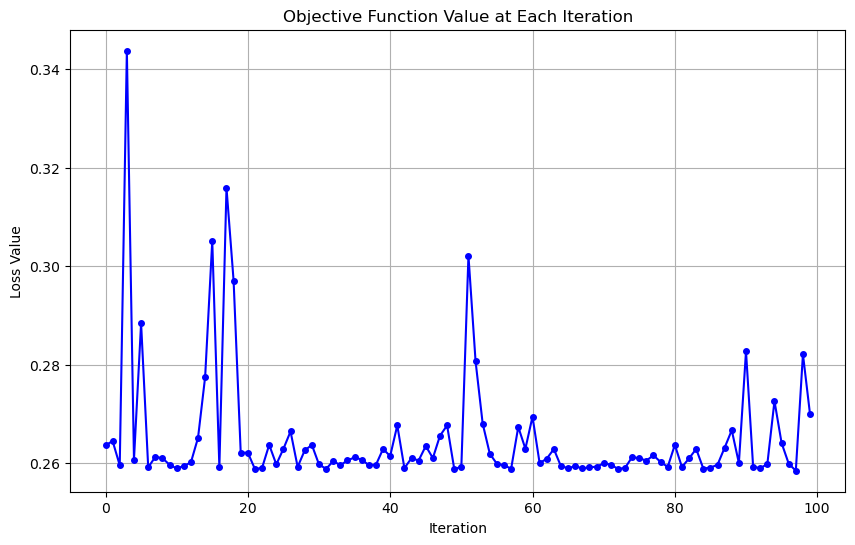

In [6]:
# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(df_past.drop(columns=['default']),
                                                    df_past['default'],
                                                    test_size=0.2,
                                                    random_state=42)
y_train = y_train[X_train.income < 140_000]
X_train = X_train[X_train.income < 140_000]



# Objective function for hyperopt
def objective(params):
    model = CatBoostRegressor(
        iterations=500,
        learning_rate=params['learning_rate'],
        depth=int(params['depth']),
        l2_leaf_reg=params['l2_leaf_reg'],
#        border_count=params['border_count'],
        grow_policy=params['grow_policy'],
        min_data_in_leaf=params['min_data_in_leaf'],
        bootstrap_type=params['bootstrap_type'],
        cat_features=X_train.select_dtypes(['category']).columns.tolist(),  # Handle categorical features
        logging_level='Silent'
    )
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_pred[X_test.income >= 140_000] = 0
    loss = 1 - roc_auc_score(y_test, y_pred)
    return {'loss': loss, 'status': STATUS_OK}


# Search space
# Expanded Search space
space = {
    'learning_rate': hp.loguniform('learning_rate', -7, 0),
    'depth': hp.quniform('depth', 4, 10, 1),
    'l2_leaf_reg': hp.uniform('l2_leaf_reg', 0, 5),
#    'border_count': hp.quniform('border_count', 1, 255, 5),
    'grow_policy': hp.choice('grow_policy', ["SymmetricTree", "Depthwise", "Lossguide"]),
    'min_data_in_leaf': hp.qloguniform('min_data_in_leaf', 0, 6, 1),
    'bootstrap_type': hp.choice('bootstrap_type', ["Bayesian", "Bernoulli", "MVS", "No"]),


#    'bagging_temperature': hp.uniform('bagging_temperature', 0, 1)
}



# Then use the same fmin function and objective function to find the best hyperparameters.


# Run the optimizer
trials = Trials()
best_cat = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=100, trials=trials)

#print(f"Best hyperparameters:\n{best}")

losses = [x['result']['loss'] for x in trials.trials]

plt.figure(figsize=(10, 6))
plt.plot(losses, '-o', color='blue', markersize=4)
plt.title('Objective Function Value at Each Iteration')
plt.xlabel('Iteration')
plt.ylabel('Loss Value')
plt.grid(True)
plt.show()

In [7]:
best_cat

{'bootstrap_type': 2,
 'depth': 7.0,
 'grow_policy': 0,
 'l2_leaf_reg': 2.658849283525596,
 'learning_rate': 0.03669204959940085,
 'min_data_in_leaf': 7.0}

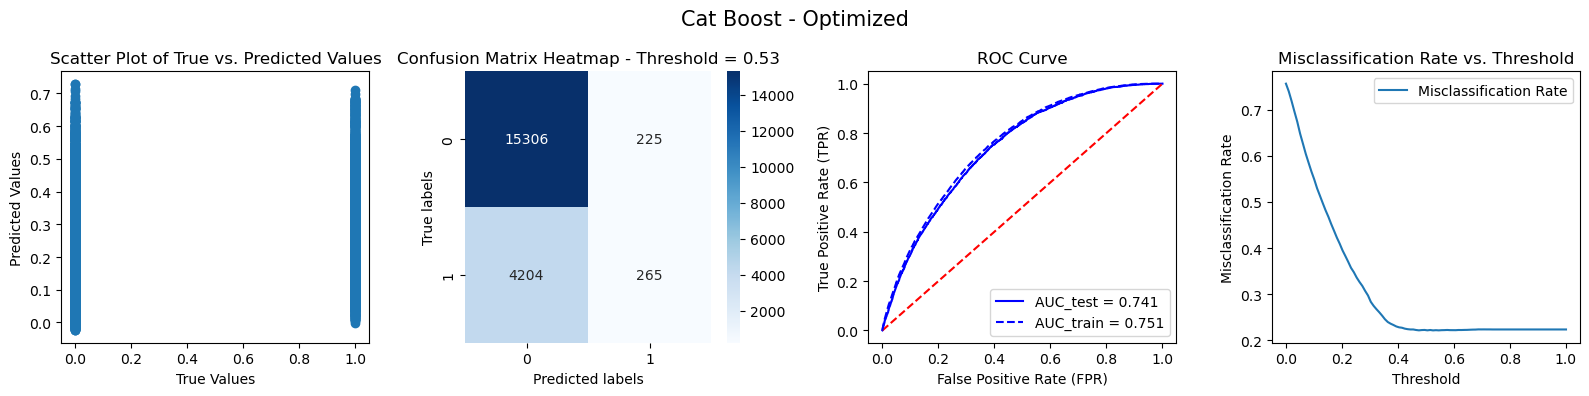

In [9]:
# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(df_past.drop(columns=['default']),
                                                    df_past['default'],
                                                    test_size=0.2,
                                                    random_state=42)

y_train_poor = y_train[X_train.income < 140_000]
X_train_poor = X_train[X_train.income < 140_000]

# Ensure `best` is available and contains the necessary hyperparameters
assert 'bootstrap_type' in best_cat and 'grow_policy' in best_cat

# Map the hyperparameters
best_hyperparameters = best_cat.copy()

best_hyperparameters['bootstrap_type'] = ["Bayesian", "Bernoulli", "MVS", "No"][best_cat['bootstrap_type']]
best_hyperparameters['grow_policy'] = ["SymmetricTree", "Depthwise", "Lossguide"][best_cat['grow_policy']]
best_hyperparameters['depth'] = int(best_cat['depth'])
#best_hyperparameters['border_count'] = int(best['border_count'])

# Add categorical features
cat_features = X_train_poor.select_dtypes(['category']).columns.tolist()
best_hyperparameters['cat_features'] = cat_features

# Initialize the regressor
regressor_cat = CatBoostRegressor(**best_hyperparameters, logging_level='Silent') 

# Fit the model
regressor_cat.fit(X_train_poor, y_train_poor)

# Predict
y_pred = regressor_cat.predict(X_test)
y_pred[X_test.income >= 140_000] = 0

y_pred_train = regressor_cat.predict(X_train)
y_pred_train[X_train.income >= 140_000] = 0

# Ensure the plot_func exists
if 'plot_func' in globals():
    plot_func(y_test, y_pred, train=(y_train, y_pred_train), name='Cat Boost - Optimized')
else:
    print("plot_func is not defined!")


### XGBoost

100%|███████| 100/100 [01:22<00:00,  1.21trial/s, best loss: 0.2593132259506712]


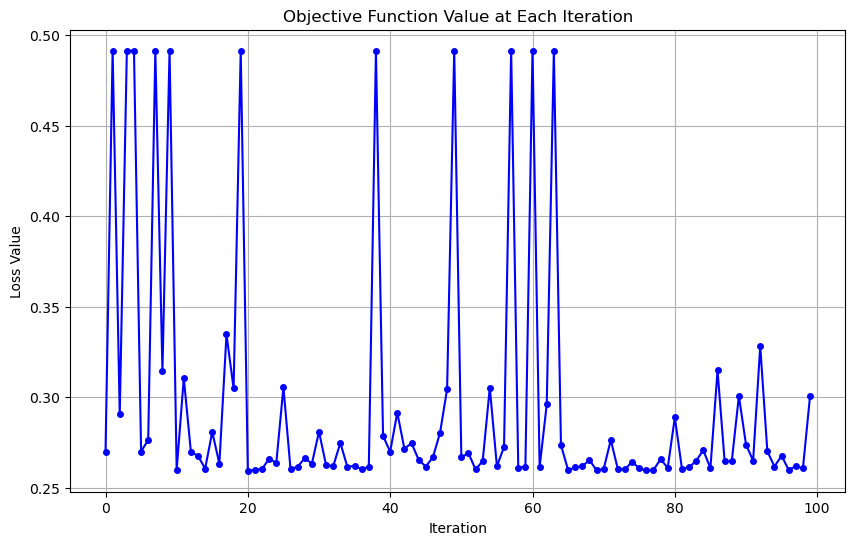

In [11]:
# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(df_past.drop(columns=['default']),
                                                    df_past['default'],
                                                    test_size=0.2,
                                                    random_state=42)


y_train_poor = y_train[X_train.income < 140_000]
X_train_poor = X_train[X_train.income < 140_000]


# Objective function for hyperopt
def objective(params):
    model = xgb.XGBRegressor(
        n_estimators=500,
        learning_rate=params['learning_rate'],
        max_depth=int(params['max_depth']),
        gamma=params['gamma'],
        colsample_bytree=params['colsample_bytree'],
        subsample=params['subsample'],
        reg_lambda=params['reg_lambda'],
        enable_categorical=True,
        eval_metric='auc'
    )
    model.fit(X_train_poor, y_train_poor)
    y_pred = model.predict(X_test)
    y_pred[X_test.income >= 140_000] = 0
    loss = 1 - roc_auc_score(y_test, y_pred)
    return {'loss': loss, 'status': STATUS_OK}

# Search space
space = {
    'learning_rate': hp.loguniform('learning_rate', -7, 0),
    'max_depth': hp.quniform('max_depth', 1, 8, 1),
    'gamma': hp.loguniform('gamma', -10, 10),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1),
    'subsample': hp.uniform('subsample', 0.5, 1),
    'reg_lambda': hp.uniform('reg_lambda', 0, 10),
    'min_child_weight': hp.loguniform('min_child_weight', -2, 3),
    'reg_alpha': hp.uniform('reg_alpha', 0, 10),
    'random_state':42
}

# Run the optimizer
trials = Trials()
best_xgb = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=100,
            trials=trials)

#print(f"Best hyperparameters:\n{best}")

losses = [x['result']['loss'] for x in trials.trials]

plt.figure(figsize=(10, 6))
plt.plot(losses, '-o', color='blue', markersize=4)
plt.title('Objective Function Value at Each Iteration')
plt.xlabel('Iteration')
plt.ylabel('Loss Value')
plt.grid(True)
plt.show()

In [12]:
best_xgb

{'colsample_bytree': 0.8266988794969539,
 'gamma': 1.1445756367351836,
 'learning_rate': 0.04821692999018296,
 'max_depth': 6.0,
 'min_child_weight': 1.0337098876613546,
 'reg_alpha': 5.368920664869478,
 'reg_lambda': 2.545032673254262,
 'subsample': 0.566350013877171}

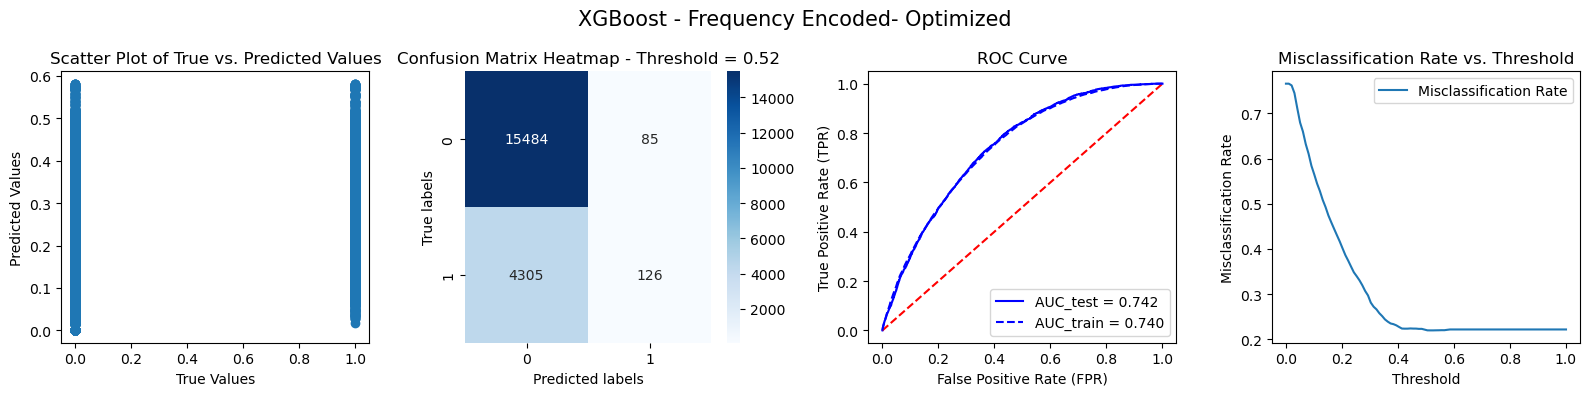

In [13]:
# 3. Split the dataset
X_train, X_test, y_train, y_test = train_test_split(df_past.drop(columns=['default']),
                                                    df_past['default'],
                                                    test_size=0.2)

y_train_poor = y_train[X_train.income < 140_000]
X_train_poor = X_train[X_train.income < 140_000]


# 5. Perform regression using CatBoost

best_xgb['max_depth'] = int(best_xgb['max_depth'])

best_hyperparameters = best_xgb

regressor_xgb = xgb.XGBRegressor(**best_hyperparameters,enable_categorical=True) # Logging level set to 'Silent' to suppress iteration-level outputs
regressor_xgb.fit(X_train_poor, y_train_poor)


# Predict
y_pred = regressor_xgb.predict(X_test)
y_pred[X_test.income >= 140_000] = 0

y_pred_train = regressor_xgb.predict(X_train)
y_pred_train[X_train.income >= 140_000] = 0

# Ensure the plot_func exists
if 'plot_func' in globals():
    plot_func(y_test, y_pred, train=(y_train, y_pred_train), name='XGBoost - Frequency Encoded- Optimized')
else:
    print("plot_func is not defined!")

## Final Pipe

In [28]:
best_xgb = {'colsample_bytree': 0.8266988794969539,
            'gamma': 1.1445756367351836,
            'learning_rate': 0.04821692999018296,
            'max_depth': 6.0,
            'min_child_weight': 1.0337098876613546,
            'reg_alpha': 5.368920664869478,
            'reg_lambda': 2.545032673254262,
            'subsample': 0.566350013877171}

In [29]:
best_cat = {'bootstrap_type': 2,
            'depth': 7.0,
            'grow_policy': 0,
            'l2_leaf_reg': 2.658849283525596,
            'learning_rate': 0.03669204959940085,
            'min_data_in_leaf': 7.0}

In [30]:
# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(df_past.drop(columns=['default']),
                                                    df_past['default'],
                                                    test_size=0.2,
                                                    random_state=42)

y_train_poor = y_train[X_train.income < 140_000]
X_train_poor = X_train[X_train.income < 140_000]

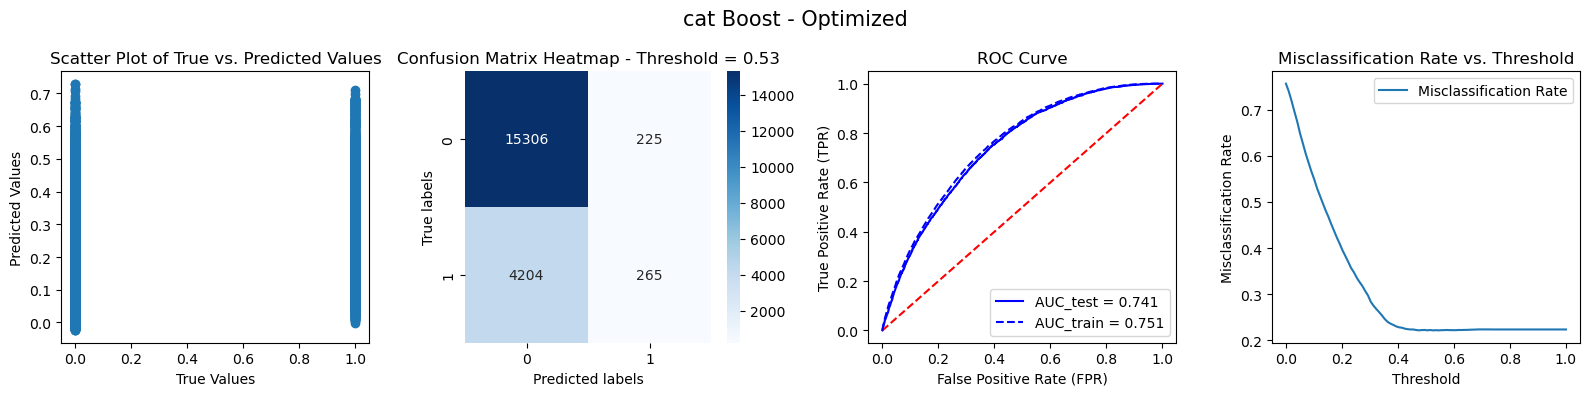

In [32]:
algo = 'cat'


if algo == 'cat':
    best_hyperparameters = best_cat.copy()
    best_hyperparameters['bootstrap_type'] = ["Bayesian", "Bernoulli", "MVS", "No"][best_cat['bootstrap_type']]
    best_hyperparameters['grow_policy'] = ["SymmetricTree", "Depthwise", "Lossguide"][best_cat['grow_policy']]
    best_hyperparameters['depth'] = int(best_cat['depth'])

    # Add categorical features
    cat_features = X_train_poor.select_dtypes(['category']).columns.tolist()
    best_hyperparameters['cat_features'] = cat_features

    # Initialize the regressor
    regressor = CatBoostRegressor(**best_hyperparameters, logging_level='Silent') 



if algo == 'xgb':
    # 5. Perform regression using CatBoost
    best_xgb['max_depth'] = int(best_xgb['max_depth'])
    best_hyperparameters = best_xgb.copy()

    regressor = xgb.XGBRegressor(**best_hyperparameters,enable_categorical=True) # Logging level set to 'Silent' to suppress iteration-level outputs

# Fit the model
regressor.fit(X_train_poor, y_train_poor)

y_pred = regressor.predict(X_test)




# Predict
y_pred = regressor.predict(X_test)
y_pred[X_test.income >= 140_000] = 0

y_pred_train = regressor.predict(X_train)
y_pred_train[X_train.income >= 140_000] = 0

# Ensure the plot_func exists
if 'plot_func' in globals():
    plot_func(y_test, y_pred, train=(y_train, y_pred_train),name=f'{algo} Boost - Optimized')
else:
    print("plot_func is not defined!")

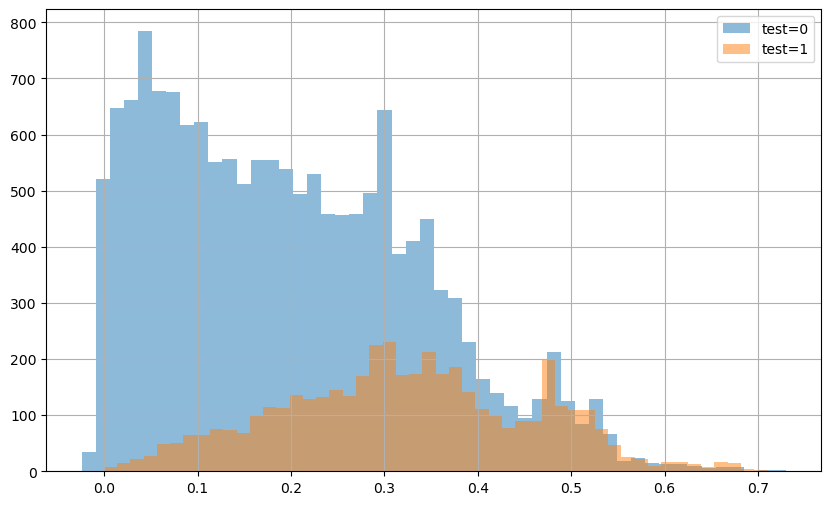

In [19]:
# Create a plot
fig, ax = plt.subplots(figsize=(10, 6))

# Group by 'test' and plot histograms
for key, group in df_.groupby(by='test'):
    group.pred.hist(ax=ax, bins=50, alpha=0.5, label=f"test={key}")

# Adding legend to differentiate between groups
ax.legend()

plt.show()

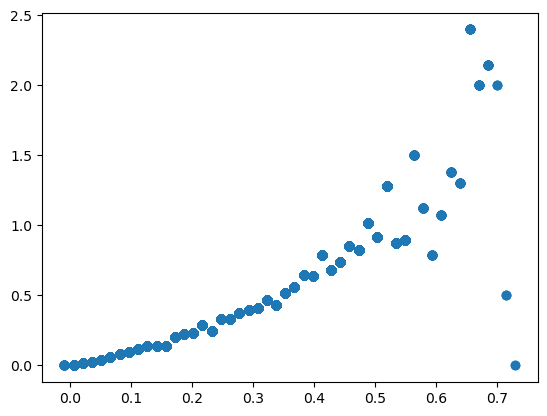

In [33]:
df_ = pd.DataFrame()
df_['pred'] = y_pred
df_['test'] = y_test.to_numpy()
df_['bins'] = pd.cut(df_['pred'], 50)
df_['risk_free_rate'] = [df_[df_.bins == x].test.mean() / (1 - df_[df_.bins == x].test.mean()) for x in df_.bins.to_numpy()]
plt.scatter(x=[x.right for x in df_.bins.to_numpy()], y=df_.risk_free_rate)

In [22]:
X_test['metric'] = df_.pred.to_numpy()

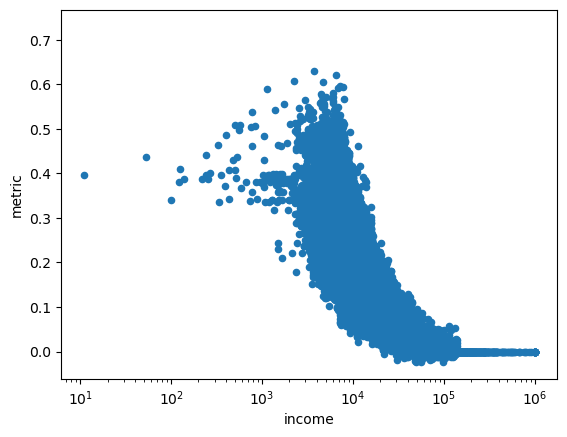

In [24]:
ax = X_test.plot.scatter(x='income', y='metric')
ax.set_xscale('log')
plt.show()


# Finding the best binning and premium rate

In [327]:
df_past = pd.read_csv('PastLoans.csv')
df_past.income = df_past.income.astype('int32')
df_past.digital1 = df_past.digital1.astype('float32')
df_past.digital2 = df_past.digital2.astype('float32')
df_past.digital3 = df_past.digital3.astype('float32')
df_past.employment = df_past.employment.astype('category')
df_past.sex = df_past.sex.astype('category')
df_past.married = df_past.married.astype('category')
df_past.default = df_past.default.astype('category')

## EDA

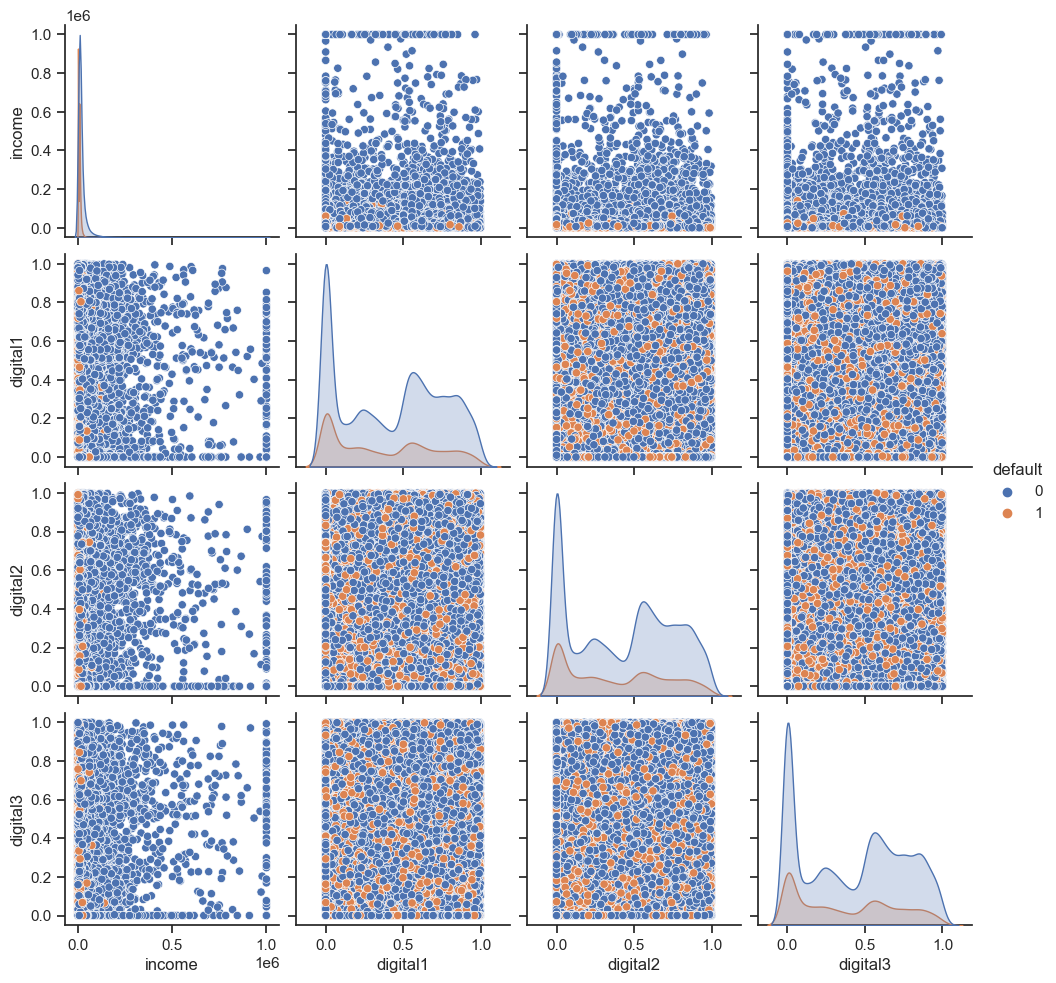

In [328]:
import seaborn as sns
sns.set_theme(style="ticks")

sns.pairplot(df_past, hue="default")

## Functions

### Train

In [42]:
def train_cat_boost(data, team):    
    # Split the dataset
    team_list = [1,2,3]
    team_list.remove(team)
    X_train, X_test, y_train, y_test = train_test_split(data.drop(columns=['default',f'digital{team_list[0]}',f'digital{team_list[1]}']),
                                                        data['default'],
                                                        test_size=0.2,
                                                        random_state=42)
    y_train = y_train[X_train.income < 140_000]
    X_train = X_train[X_train.income < 140_000]



    # Objective function for hyperopt
    def objective(params):
        model = CatBoostRegressor(
            iterations=500,
            learning_rate=params['learning_rate'],
            depth=int(params['depth']),
            l2_leaf_reg=params['l2_leaf_reg'],
    #        border_count=params['border_count'],
            grow_policy=params['grow_policy'],
            min_data_in_leaf=params['min_data_in_leaf'],
            bootstrap_type=params['bootstrap_type'],
            cat_features=X_train.select_dtypes(['category']).columns.tolist(),  # Handle categorical features
            logging_level='Silent'
        )
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_pred[X_test.income >= 140_000] = 0
        loss = 1 - roc_auc_score(y_test, y_pred)
        return {'loss': loss, 'status': STATUS_OK}


    # Search space
    # Expanded Search space
    space = {
        'learning_rate': hp.loguniform('learning_rate', -7, 0),
        'depth': hp.quniform('depth', 4, 10, 1),
        'l2_leaf_reg': hp.uniform('l2_leaf_reg', 0, 5),
    #    'border_count': hp.quniform('border_count', 1, 255, 5),
        'grow_policy': hp.choice('grow_policy', ["SymmetricTree", "Depthwise", "Lossguide"]),
        'min_data_in_leaf': hp.qloguniform('min_data_in_leaf', 0, 6, 1),
        'bootstrap_type': hp.choice('bootstrap_type', ["Bayesian", "Bernoulli", "MVS", "No"]),
    
    
    #    'bagging_temperature': hp.uniform('bagging_temperature', 0, 1)
    }



    # Then use the same fmin function and objective function to find the best hyperparameters.


    # Run the optimizer
    trials = Trials()
    best_cat = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=100, trials=trials)
    return(best_cat)

### Pred

In [363]:
def get_pred(params, data, team):

    team_list = [1,2,3]
    team_list.remove(team)
    X_train, X_test, y_train, y_test = train_test_split(data.drop(columns=['default',f'digital{team_list[0]}',f'digital{team_list[1]}']),
                                                        data['default'],
                                                        test_size=0.2,
                                                        random_state=42)
    y_train_ = y_train[X_train.income < 140_000]
    X_train_ = X_train[X_train.income < 140_000]


    best_hyperparameters = params.copy()
    best_hyperparameters['bootstrap_type'] = ["Bayesian", "Bernoulli", "MVS", "No"][params['bootstrap_type']]
    best_hyperparameters['grow_policy'] = ["SymmetricTree", "Depthwise", "Lossguide"][params['grow_policy']]
    best_hyperparameters['depth'] = int(params['depth'])

    # Add categorical features
    cat_features = X_train.select_dtypes(['category']).columns.tolist()
    best_hyperparameters['cat_features'] = cat_features

    # Initialize the regressor
    regressor = CatBoostRegressor(**best_hyperparameters, logging_level='Silent') 

    regressor.fit(X_train_,y_train_)

    #y_pred = regressor.predict(X_test)
    #y_pred[X_test.income >= 140_000] = 0
    y_pred = regressor.predict(pd.concat([X_train, X_test]))
    y_pred[pd.concat([X_train, X_test]).income >= 140_000] = 0

    return(y_pred, pd.concat([y_train, y_test]))

### Others funcs

In [387]:
def get_lending_rate(y_list, nbr_bins=10):
    df_ = pd.DataFrame()
    df_[f'default'] = y_list[0][1].to_numpy()
    for i, elem in enumerate(y_list):
        df_[f'pred_team{i+1}'] = elem[0]
        df_[f'bins_team{i+1}'] = pd.qcut(df_[f'pred_team{i+1}'], nbr_bins)
        df_[f'BEIR_{i+1}'] = ([df_[df_[f'bins_team{i+1}'] == x].default.mean() 
                                            / (1 - df_[df_[f'bins_team{i+1}'] == x].default.mean())
                                            for x in tqdm(df_[f'bins_team{i+1}'].to_numpy())])
        df_ = df_.drop(columns=[f'bins_team{i+1}'])
    df_['prefered_lender'] = np.random.choice([1,2,3], size=100000)
    return(df_)

In [388]:
def add_premium(df,premium_list):
    df_ = df.copy()
    for i, rate in enumerate(premium_list):
        df_[f'tot_rate_{i+1}'] =  df_[f'BEIR_{i+1}'] + rate/100
    return(df_)

In [488]:
def gain_compute(df_all):
    team_list_all = [1, 2, 3]
    gain_list = []

    for team in team_list_all:
        team_list = team_list_all.copy()
        team_list.remove(team)

        condition1 = (df_all[f'tot_rate_{team}'] + .02 <= df_all[f'tot_rate_{team_list[0]}'])
        condition2 = (df_all[f'tot_rate_{team}'] <= df_all[f'tot_rate_{team_list[1]}'])
        condition3 = (df_all[f'tot_rate_{team}'] < 1)
        condition4 = (df_all.prefered_lender == team_list[0])

        condition5 = (df_all[f'tot_rate_{team}'] <= df_all[f'tot_rate_{team_list[0]}'])
        condition6 = (df_all[f'tot_rate_{team}'] + .02 <= df_all[f'tot_rate_{team_list[1]}'])
        condition7 = (df_all.prefered_lender == team_list[1])


        condition8 = (df_all[f'tot_rate_{team}'] < df_all[f'tot_rate_{team_list[0]}'] + .02)
        condition9 = (df_all[f'tot_rate_{team}'] < df_all[f'tot_rate_{team_list[1]}'] + .02)
        condition10 = (df_all.prefered_lender == team)

        df_gain = pd.concat([
            df_all[condition1 & condition2 & condition3 & condition4].copy(),
            df_all[condition5 & condition6 & condition3 & condition7].copy(),
            df_all[condition8 & condition9 & condition3 & condition10].copy()
        ])

        df_gain['gain'] = -10000 * df_gain.default + 10000 * (df_gain[f'tot_rate_{team}']) * (df_gain.default.replace({0: 1, 1: 0}))

        gain_list.append(df_gain.gain.sum())

    return gain_list


## Main

In [45]:
params_1 = train_cat_boost(df_past, 1)
params_2 = train_cat_boost(df_past, 2)
params_3 = train_cat_boost(df_past, 3)

100%|██████| 100/100 [06:15<00:00,  3.76s/trial, best loss: 0.25848502937822526]


In [364]:
team_list = [1,2,3]
y_result_list = []
for team in team_list:
    y_result_list.append(get_pred(eval(f'params_{team}'), df_past, team))

In [390]:
df_result = get_lending_rate(y_result_list, nbr_bins=30)

100%|█████████████████████████████████| 100000/100000 [00:50<00:00, 1970.63it/s]


In [391]:
df_result.head()

,default,pred_team1,BEIR_1,pred_team2,BEIR_2,pred_team3,BEIR_3,prefered_lender
0,0,0.116053,0.124873,0.095402,0.110260,0.100460,0.104339,1
1,1,0.248212,0.315312,0.375181,0.617918,0.293432,0.386023,2
2,0,0.169061,0.209800,0.305710,0.427281,0.268424,0.384392,2
3,0,0.149704,0.158901,0.138789,0.148467,0.146088,0.169474,3
4,0,0.190164,0.236188,0.133978,0.148467,0.265582,0.320523,2


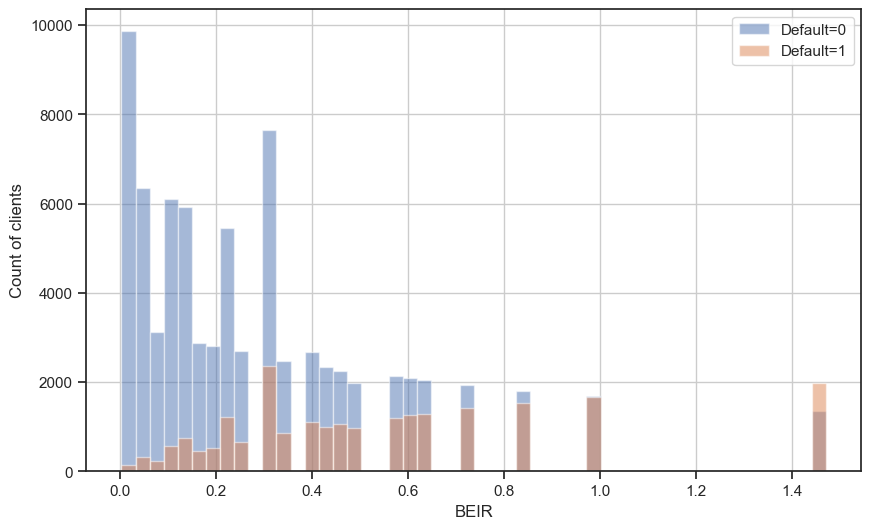

In [477]:
# Create a plot
fig, ax = plt.subplots(figsize=(10, 6))

# Group by 'test' and plot histograms
for key, group in df_result.groupby(by='default'):
    group.BEIR_1.hist(ax=ax, bins=50, alpha=0.5, label=f"Default={key}")

# Adding legend to differentiate between groups
ax.legend()
ax.set_xlabel('BEIR')
ax.set_ylabel('Count of clients')

plt.show()

In [497]:
df_all = add_premium(df_result,[2,2,3.9])
df_all['prefered_lender'] = np.random.choice([1,2,3], size=100000)
df_all.head()

,default,pred_team1,BEIR_1,pred_team2,BEIR_2,pred_team3,BEIR_3,prefered_lender,tot_rate_1,tot_rate_2,tot_rate_3
0,0,0.116053,0.124873,0.095402,0.110260,0.100460,0.104339,1,0.144873,0.130260,0.143339
1,1,0.248212,0.315312,0.375181,0.617918,0.293432,0.386023,2,0.335312,0.637918,0.425023
2,0,0.169061,0.209800,0.305710,0.427281,0.268424,0.384392,1,0.229800,0.447281,0.423392
3,0,0.149704,0.158901,0.138789,0.148467,0.146088,0.169474,2,0.178901,0.168467,0.208474
4,0,0.190164,0.236188,0.133978,0.148467,0.265582,0.320523,2,0.256188,0.168467,0.359523


In [498]:
df_past.default.astype('int32').mean() / (1 - df_past.default.astype('int32').mean())

0.29018939980389125

In [499]:
df_all[['BEIR_1','BEIR_2','BEIR_3']].mean(axis=0)

BEIR_1    0.352915
BEIR_2    0.348682
BEIR_3    0.349612
dtype: float64

In [500]:
gain_compute(df_all)

[-8133200.189194543, -17331070.520883217, -9777216.520285465]

100%|█████████████████████████████████████████| 400/400 [00:04<00:00, 90.12it/s]


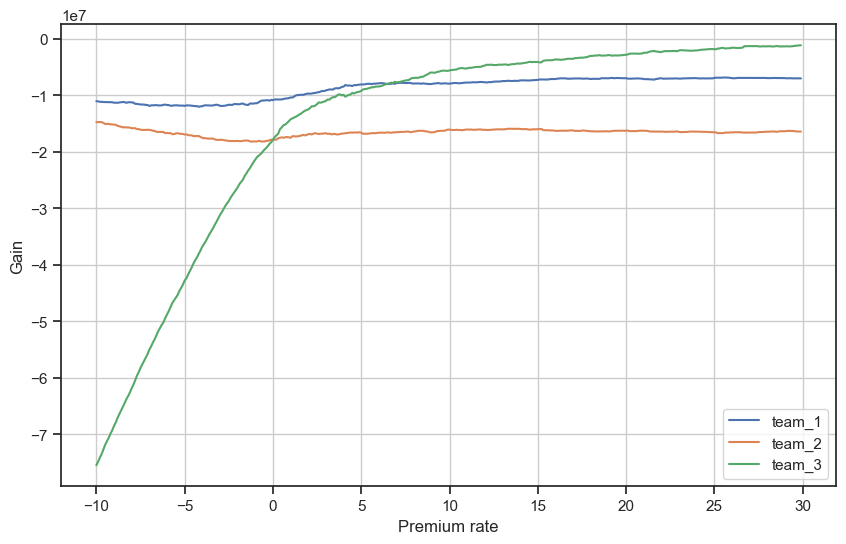

In [492]:
premium_list = np.arange(-10,30,0.1)
gain_team_1_list = []
gain_team_2_list = []
gain_team_3_list = []
for premium in tqdm(premium_list):
    df_all = add_premium(df_result,[2,2,premium])
    gain_list = gain_compute(df_all)
    gain_team_1_list.append(gain_list[0])
    gain_team_2_list.append(gain_list[1])
    gain_team_3_list.append(gain_list[2])
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(premium_list, gain_team_1_list,label=('team_1'))
ax.plot(premium_list, gain_team_2_list,label=('team_2'))
ax.plot(premium_list, gain_team_3_list,label=('team_3'))
ax.legend()
ax.set_xlabel('Premium rate')
ax.set_ylabel('Gain')
plt.grid()

# Submission

In [417]:
df_new = pd.read_csv('NewApplications_Lender3.csv')
df_new.income = df_new.income.astype('int32')
df_new.digital3 = df_new.digital3.astype('float32')
df_new.employment = df_new.employment.astype('category')
df_new.sex = df_new.sex.astype('category')
df_new.married = df_new.married.astype('category')

In [418]:
df_new

,id,sex,employment,married,income,digital3
0,1,1,unemployed,1,16514,0.000000
1,2,0,employed,1,8842,0.000000
2,3,0,employed,0,19424,0.596771
3,4,1,unemployed,1,7418,0.622311
4,5,1,retired,0,843,0.388930
...,...,...,...,...,...,...
99995,99996,1,student,0,0,0.933285
99996,99997,1,employed,1,18066,0.567901
99997,99998,1,employed,0,7273,0.669176
99998,99999,1,employed,1,8238,0.075339


In [437]:
def get_pred_final(params, data_old, data_new):


    X_train, X_test, y_train, y_test = train_test_split(data_old.drop(columns=['default','digital1','digital2']),
                                                        data_old['default'],
                                                        test_size=1,
                                                        random_state=42)
    y_train_ = y_train[X_train.income < 140_000]
    X_train_ = X_train[X_train.income < 140_000]


    best_hyperparameters = params.copy()
    best_hyperparameters['bootstrap_type'] = ["Bayesian", "Bernoulli", "MVS", "No"][params['bootstrap_type']]
    best_hyperparameters['grow_policy'] = ["SymmetricTree", "Depthwise", "Lossguide"][params['grow_policy']]
    best_hyperparameters['depth'] = int(params['depth'])

    # Add categorical features
    cat_features = X_train.select_dtypes(['category']).columns.tolist()
    print(X_train.columns.tolist())
    print(cat_features)
    best_hyperparameters['cat_features'] = ['married','sex','employment']

    # Initialize the regressor
    regressor = CatBoostRegressor(**best_hyperparameters, logging_level='Silent') 

    regressor.fit(X_train_,y_train_)

    #y_pred = regressor.predict(X_test)
    #y_pred[X_test.income >= 140_000] = 0
    print(data_new.drop(columns=['id']).columns.tolist())
    y_pred = regressor.predict(data_new.drop(columns=['id']))
    y_pred[data_new.income >= 140_000] = 0
    data_new['PD'] = y_pred
    return(data_new)

In [438]:
df_new_1 = get_pred_final(params_3, df_past, df_new)

['sex', 'employment', 'married', 'income', 'digital3']
['sex', 'employment', 'married']
['sex', 'employment', 'married', 'income', 'digital3', 'BEIR']


In [439]:
df_new_1

,id,sex,employment,married,income,digital3,BEIR,PD
0,1,1,unemployed,1,16514,0.000000,0.068963,0.068963
1,2,0,employed,1,8842,0.000000,0.243160,0.243160
2,3,0,employed,0,19424,0.596771,0.098341,0.098341
3,4,1,unemployed,1,7418,0.622311,0.233908,0.233908
4,5,1,retired,0,843,0.388930,0.420368,0.420368
...,...,...,...,...,...,...,...,...
99995,99996,1,student,0,0,0.933285,0.294427,0.294427
99996,99997,1,employed,1,18066,0.567901,0.103938,0.103938
99997,99998,1,employed,0,7273,0.669176,0.283276,0.283276
99998,99999,1,employed,1,8238,0.075339,0.444458,0.444458


In [443]:
df_new_1['bins'] = pd.qcut(df_new_1.PD, 30)
df_new_1['BEIR'] = ([df_new_1[df_new_1['bins'] == x].PD.mean() 
                                            / (1 - df_new_1[df_new_1['bins'] == x].PD.mean() )
                                            for x in tqdm(df_new_1['bins'].to_numpy())])

100%|█████████████████████████████████| 100000/100000 [00:57<00:00, 1734.01it/s]


In [445]:
df_new_1['tot_rate'] = df_new_1.BEIR + 0.039

In [446]:
df_new_1

,id,sex,employment,married,income,digital3,BEIR,PD,bins,tot_rate
0,1,1,unemployed,1,16514,0.000000,0.077294,0.068963,"(0.0648, 0.0788]",0.116294
1,2,0,employed,1,8842,0.000000,0.311292,0.243160,"(0.229, 0.245]",0.350292
2,3,0,employed,0,19424,0.596771,0.111915,0.098341,"(0.0934, 0.108]",0.150915
3,4,1,unemployed,1,7418,0.622311,0.311292,0.233908,"(0.229, 0.245]",0.350292
4,5,1,retired,0,843,0.388930,0.712893,0.420368,"(0.399, 0.435]",0.751893
...,...,...,...,...,...,...,...,...,...,...
99995,99996,1,student,0,0,0.933285,0.426763,0.294427,"(0.293, 0.306]",0.465763
99996,99997,1,employed,1,18066,0.567901,0.111915,0.103938,"(0.0934, 0.108]",0.150915
99997,99998,1,employed,0,7273,0.669176,0.400601,0.283276,"(0.279, 0.293]",0.439601
99998,99999,1,employed,1,8238,0.075339,0.851637,0.444458,"(0.435, 0.477]",0.890637


In [459]:
df_new_1.isna().sum()

id            0
sex           0
employment    0
married       0
income        0
digital3      0
BEIR          0
PD            0
bins          0
tot_rate      0
dtype: int64

In [470]:
df_final = df_new_1[['id','tot_rate']].copy()
df_final

,id,tot_rate
0,1,0.116294
1,2,0.350292
2,3,0.150915
3,4,0.350292
4,5,0.751893
...,...,...
99995,99996,0.465763
99996,99997,0.150915
99997,99998,0.439601
99998,99999,0.890637


In [471]:
df_final.loc[df_final.tot_rate > 1, 'tot_rate'] = np.nan

In [472]:
df_final[df_final.tot_rate>1]

,id,tot_rate


In [473]:
df_final

,id,tot_rate
0,1,0.116294
1,2,0.350292
2,3,0.150915
3,4,0.350292
4,5,0.751893
...,...,...
99995,99996,0.465763
99996,99997,0.150915
99997,99998,0.439601
99998,99999,0.890637


In [475]:
df_final.to_csv('submission_group_3.csv', index=False)

In [474]:
df_final.isna().sum()

id             0
tot_rate    6176
dtype: int64

In [454]:
df_final[df_final>1]

,id,tot_rate
0,NaN,NaN
1,2.0,NaN
2,3.0,NaN
3,4.0,NaN
4,5.0,NaN
...,...,...
99995,99996.0,NaN
99996,99997.0,NaN
99997,99998.0,NaN
99998,99999.0,NaN
